In [46]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt 
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.vector_ar.var_model import VAR

import warnings
warnings.simplefilter('ignore')

## DATOS

Tomamos datos experimentales de Kaggle. [Seattle Burke Gilman Trail](https://www.kaggle.com/city-of-seattle/seattle-burke-gilman-trail) es un conjunto de datos de la ciudad de Seattle que forma parte de su proyecto de datos abiertos. El conjunto de datos almacena series de conteo por horas detectadas por sensores. Estos sensores cuentan tanto a las personas que van en bicicleta como a los peatones. Se contabilizan volúmenes separados para cada modo de viaje. En total hay 5 series: 2 relacionadas con el conteo de peatones, 2 relacionadas con el conteo de bicicletas, y el total que es la suma de las serie anteriores. Hay contadores dobles para peatones y bicicletas porque se registran las dos direcciones de viaje.

In [47]:
### Cargar los datos ###

train_hours = 80*7*24  # weeks x hours x days
test_hours = 15*7*24  # weeks x hours x days

df = pd.read_csv('burke-gilman-trail-north-of-ne-70th-st-bike-and-ped-counter.csv', nrows=train_hours+test_hours, parse_dates=['Date'])

print(df.shape)
df.head()

(15960, 6)


,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,2014-01-01 00:00:00,15.0,0.0,2.0,2.0,11.0
1,2014-01-01 01:00:00,9.0,1.0,0.0,1.0,7.0
2,2014-01-01 02:00:00,9.0,0.0,0.0,0.0,9.0
3,2014-01-01 03:00:00,19.0,0.0,0.0,0.0,19.0
4,2014-01-01 04:00:00,19.0,0.0,0.0,0.0,19.0


In [48]:
### NANs ###
df.isna().sum()

Date                          0
BGT North of NE 70th Total    4
Ped South                     4
Ped North                     4
Bike North                    4
Bike South                    4
dtype: int64

In [49]:
df['Ped South'] = df['Ped South'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Ped North'] = df['Ped North'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Bike South'] = df['Bike South'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['Bike North'] = df['Bike North'].groupby(df.Date.dt.hour).transform(lambda x: x.fillna(x.median()))
df['BGT North of NE 70th Total'] = df['Ped South'] + df['Ped North'] + df['Bike South'] + df['Bike North']

In [50]:
df.isna().sum()

Date                          0
BGT North of NE 70th Total    0
Ped South                     0
Ped North                     0
Bike North                    0
Bike South                    0
dtype: int64

In [51]:
### AGREGACION DIARIA ###
df['Date'] = pd.to_datetime(df['Date'].dt.date)
df.head()

,Date,BGT North of NE 70th Total,Ped South,Ped North,Bike North,Bike South
0,2014-01-01,15.0,0.0,2.0,2.0,11.0
1,2014-01-01,9.0,1.0,0.0,1.0,7.0
2,2014-01-01,9.0,0.0,0.0,0.0,9.0
3,2014-01-01,19.0,0.0,0.0,0.0,19.0
4,2014-01-01,19.0,0.0,0.0,0.0,19.0


In [52]:
df_day = pd.DataFrame()
df_day['Ped South'] = df.groupby(df.Date)['Ped South'].sum()
df_day['Ped North'] = df.groupby(df.Date)['Ped North'].sum()
df_day['Bike South'] = df.groupby(df.Date)['Bike South'].sum()
df_day['Bike North'] = df.groupby(df.Date)['Bike North'].sum()
df_day['Total'] = df.groupby(df.Date)['BGT North of NE 70th Total'].sum()

df_day.index = pd.DatetimeIndex(df_day.index.values, freq=df_day.index.inferred_freq)
df_day.head()

,Ped South,Ped North,Bike South,Bike North,Total
2014-01-01,187.0,189.0,134.0,403.0,913.0
2014-01-02,114.0,64.0,391.0,189.0,758.0
2014-01-03,148.0,146.0,307.0,308.0,909.0
2014-01-04,221.0,207.0,484.0,461.0,1373.0
2014-01-05,188.0,187.0,327.0,325.0,1027.0


In [53]:
print(df_day.shape)

(665, 5)


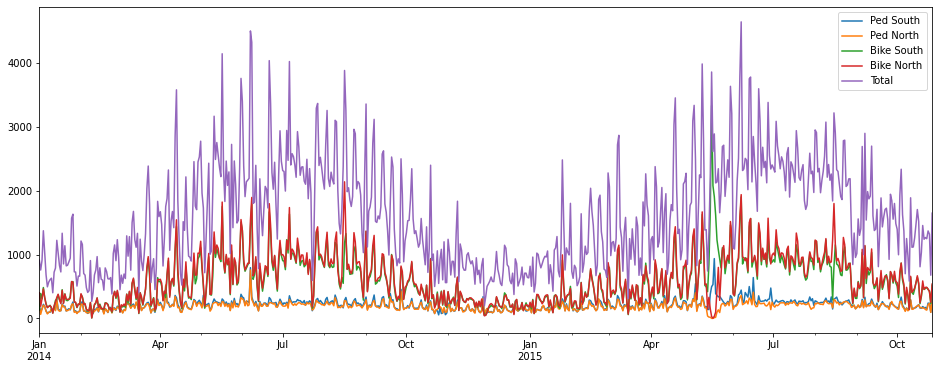

In [54]:
### PLOT DATOS DIARIOS ###

df_day.plot(figsize=(16,6))

In [55]:
### TRAIN SPLIT ###

train = df_day[:(train_hours//24)].copy()

train.shape

(560, 5)

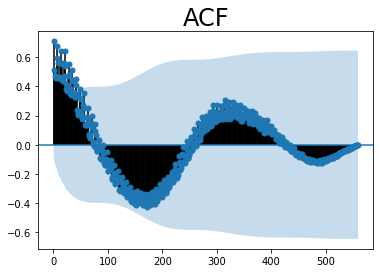

In [56]:
### ACF ### 
sgt.plot_acf(train['Total'], lags = 559, zero = False)
plt.title("ACF", size = 24)
plt.show()

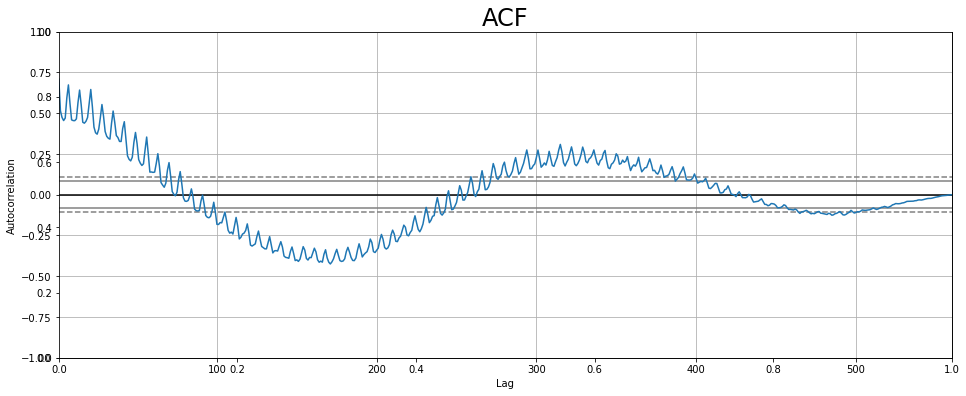

In [57]:
plt.figure(figsize=(16,6))
plt.title("ACF", size = 24)
pd.plotting.autocorrelation_plot(train['Total']);

In [58]:
### MEDIA MENUSAL ###
month_mean_train = train.groupby(train.index.month).mean()
month_mean_train

,Ped South,Ped North,Bike South,Bike North,Total
1,163.983871,154.080645,296.483871,302.096774,916.645161
2,163.875000,155.660714,297.035714,302.642857,919.214286
3,190.983871,180.580645,413.580645,429.274194,1214.419355
4,223.516667,206.533333,586.400000,622.816667,1639.266667
5,275.790323,193.000000,968.435484,794.983871,2232.209677
6,291.116667,240.416667,919.533333,967.383333,2418.450000
7,254.733333,222.000000,933.066667,987.155556,2396.955556
8,246.387097,216.129032,832.629032,941.483871,2236.629032
9,230.500000,208.333333,646.566667,678.600000,1764.000000
10,160.741935,164.290323,421.129032,428.741935,1174.903226


In [59]:
### REMOVER 'LONG TERM SEASONALITY' (ESTACIONALIDAD ANUAL EN ESTE CASO) ###

train['Ped South'] = train.apply(lambda x: x['Ped South'] - month_mean_train['Ped South'][x.name.month], axis=1)
train['Ped North'] = train.apply(lambda x: x['Ped North'] - month_mean_train['Ped North'][x.name.month], axis=1)
train['Bike South'] = train.apply(lambda x: x['Bike South'] - month_mean_train['Bike South'][x.name.month], axis=1)
train['Bike North'] = train.apply(lambda x: x['Bike North'] - month_mean_train['Bike North'][x.name.month], axis=1)
train['Total'] = train.apply(lambda x: x['Total'] - month_mean_train['Total'][x.name.month], axis=1)

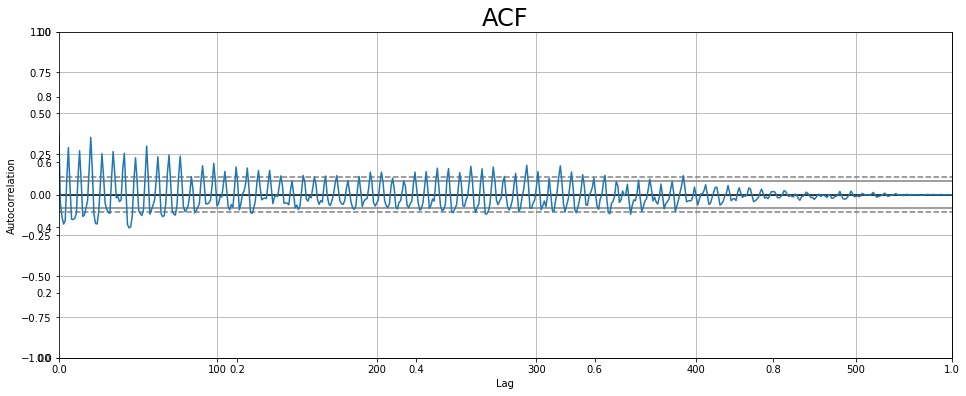

In [60]:
### ACF ###

plt.figure(figsize=(16,6))
plt.title("ACF", size = 24)
pd.plotting.autocorrelation_plot(train['Total']);

# DETECCIÓN DE ATÍPICOS UNIVARIANTES

In [61]:
### TRAIN TEST SPLIT - CASO UNIVARIANTE ###

train_uni = train['Total'].copy()
test_uni = df_day['Total'][(train_hours//24):].copy()
test_uni = test_uni - test_uni.index.month.map(month_mean_train['Total'])
train.drop('Total', inplace=True, axis=1)

In [62]:
### MODELO UNIVARIANTE ###

AIC = {}
best_aic, best_order = np.inf, 0

for p in range(6,9):
    for q in range(0,10):

        mod = SARIMAX(train_uni, order=(p,0,q), enforce_invertibility=False)
        try:
            res = mod.fit(disp=False)
            AIC[(p,0,q)] = res.aic
        except:
            AIC[(p,0,q)] = np.inf
            
        if AIC[(p,0,q)] < best_aic:
            best_aic = AIC[(p,0,q)]
            best_order = (p,0,q)
            
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)


BEST ORDER (6, 0, 5) BEST AIC: 8525.476662479596


In [63]:
### Ajuste y entrenamiento del mejor modelo ###

mod = SARIMAX(train_uni, order=best_order, enforce_invertibility=False)
res = mod.fit(disp=False)
res.aic

8525.476662479596

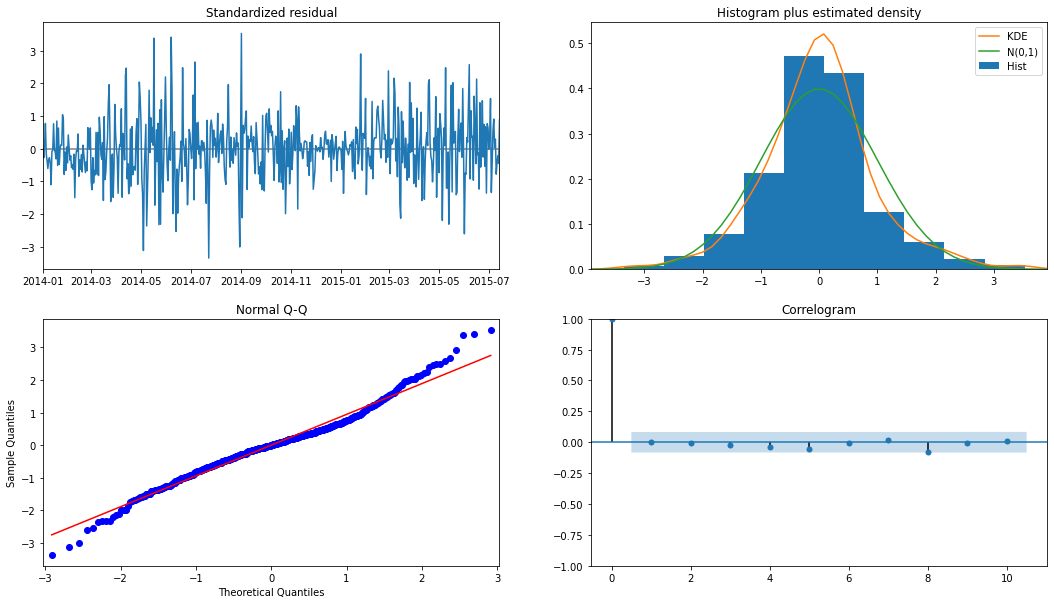

In [64]:
### Análisis de los residuos del modelo ###

res.plot_diagnostics(figsize=(18,10))
plt.show()

In [65]:
### Predicciones en los Datos de entrenamiento ###

predict = res.get_prediction()
predicted_mean = predict.predicted_mean + predict.predicted_mean.index.month.map(month_mean_train['Total'])
train_uni = train_uni + train_uni.index.month.map(month_mean_train['Total'])
predict_ci = predict.conf_int(alpha=0.1)
predict_ci['lower Total'] = predict_ci.apply(lambda x: x['lower Total'] + month_mean_train['Total'][x.name.month], axis=1)
predict_ci['upper Total'] = predict_ci.apply(lambda x: x['upper Total'] + month_mean_train['Total'][x.name.month], axis=1)

residuals_mean = res.resid.mean()
residuals_std = res.resid.std()

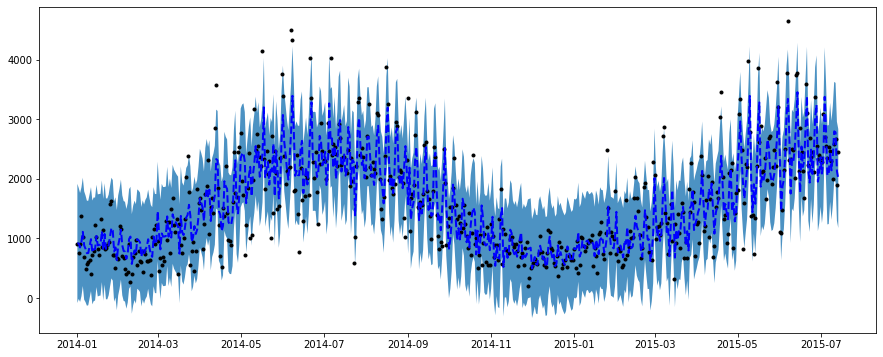

In [69]:
### PLOT Predicciones en los Datos de entrenamiento con intervalos de confianza ###

plt.figure(figsize=(15,6))

plt.plot(train_uni, 'k.')
plt.plot(predicted_mean, linestyle='--', linewidth=2, color='blue')
plt.fill_between(predict_ci.index, predict_ci['lower Total'], predict_ci['upper Total'], alpha=0.8)

In [70]:
### Predicciones iterativas en los Datos de Prueba (Test) ###

point_forecast = res.get_prediction(end=mod.nobs)
point_ci = point_forecast.conf_int(alpha=0.1)

mean_pred = {point_forecast.predicted_mean.index[-1]: point_forecast.predicted_mean[-1]}
upper_pred = {point_ci.index[-1]: point_ci['upper Total'][-1]}
lower_pred = {point_ci.index[-1]: point_ci['lower Total'][-1]}

for t,row in test_uni[:-1].iteritems():
    
    row = pd.Series(row, index=[t])
    res = res.extend(row)
    point_forecast = res.get_prediction(1)
    point_ci = point_forecast.conf_int(alpha=0.1)
    
    mean_pred[point_forecast.predicted_mean.index[0]] = point_forecast.predicted_mean.values[0]
    upper_pred[point_ci.index[0]] = point_ci['upper Total'][0]
    lower_pred[point_ci.index[0]] = point_ci['lower Total'][0]
    
mean_pred = pd.Series(mean_pred)
upper_pred = pd.Series(upper_pred)
lower_pred = pd.Series(lower_pred)

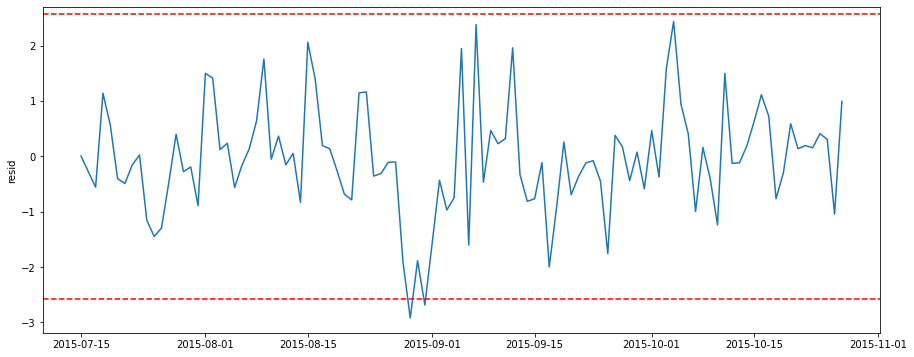

In [72]:
### Análisis de los residuos en los Datos de Prueba (Test) ###

alpha = 0.01
upper = stats.norm.ppf(1 - alpha/2)
lower = stats.norm.ppf(alpha/2)

residuals_test = test_uni - residuals_mean
residuals_test = (residuals_test - residuals_mean) / residuals_std

plt.figure(figsize=(15,6))
plt.plot(residuals_test)
plt.ylabel('resid')
plt.axhline(upper, c='red', linestyle='--')
plt.axhline(lower, c='red', linestyle='--')

In [73]:
### ¿Cuáles son los atipicos? ###

outliers_index=np.where((residuals_test<lower) | (residuals_test>upper) )[0]
outliers_index

array([45, 47])

In [74]:
### Revirtiendo el escalado en los datos de prueba predichos iterativamente ###

mean_pred = mean_pred + mean_pred.index.month.map(month_mean_train['Total'])
upper_pred = upper_pred + upper_pred.index.month.map(month_mean_train['Total'])
lower_pred = lower_pred + lower_pred.index.month.map(month_mean_train['Total'])
test_uni = test_uni + test_uni.index.month.map(month_mean_train['Total'])

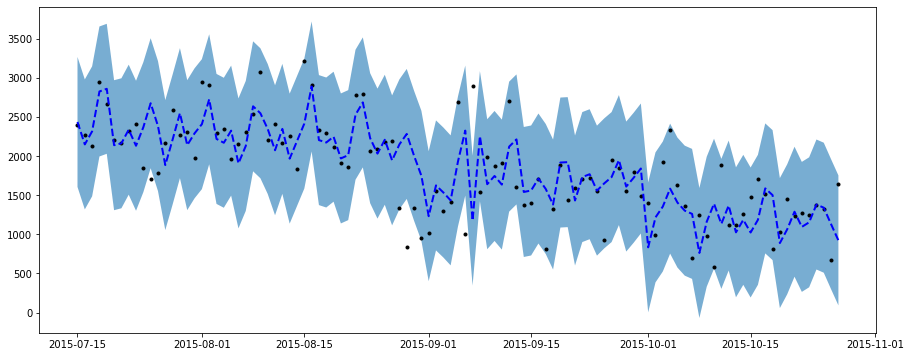

In [75]:
### PLOT Datos de prueba predichos ###

plt.figure(figsize=(15,6))

plt.plot(test_uni, 'k.')
plt.plot(mean_pred, linestyle='--', linewidth=2, color='blue')
plt.fill_between(mean_pred.index, lower_pred, upper_pred, alpha=0.6)

In [77]:
### ¿Cuáles son los atipicos? ###

outliers_index=np.where((test_uni<lower_pred) | (test_uni>upper_pred) )[0]
outliers_index

array([10, 45, 53, 54])

# DETECCIÓN DE ATÍPICOS CASO MULTIVARIANTE

In [78]:
### Mejor modelo multivariante ###

AIC = {}
best_aic, best_order = np.inf, 0

for i in range(1,50):
    model = VAR(endog=train)
    var_result = model.fit(maxlags=i)
    AIC[i] = var_result.aic
    
    if AIC[i] < best_aic:
        best_aic = AIC[i]
        best_order = i
        
print('BEST ORDER', best_order, 'BEST AIC:', best_aic)

BEST ORDER 7 BEST AIC: 34.896281239608705


In [79]:
### Entrenamiento y ajuste ###

var = VAR(endog=train)
var_result = var.fit(maxlags=best_order)

var_result.aic

34.896281239608705

El entrenamiento VAR se calcula como antes de seleccionar el mejor orden para minimizar el AIC. Los datos están estandarizados de la misma manera para eliminar la estacionalidad a largo plazo. No es de extrañar que el mejor modelo sea un VAR (7). Después de probar la independencia y normalidad de los datos residuales, se puede calcular el estadístico T-2 de Hotelling para detectar la presencia de anomalías:
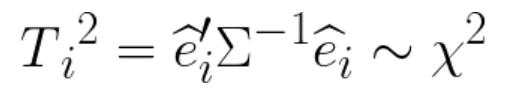



In [90]:
### Estimar la T2 de Hotelling ###

residuals_mean = var_result.resid.values.mean(axis=0)
residuals_std = var_result.resid.values.std(axis=0)

residuals = (var_result.resid.values - residuals_mean) / residuals_std
cov_residuals = np.linalg.inv(np.cov(residuals.T))

T = np.diag((residuals).dot(cov_residuals).dot(residuals.T))

Para usar el gráfico de control T2 de Hotelling se realizan dos fases: la fase de establecimiento del límite de control y la fase de seguimiento o monitorización. La primera fase se centra en la obtención de residuos del modelo, se estima el límite de control y este se utiliza en la fase dos para monitorear el proceso residual de anomalías futuras. El límite de control para el gráfico de control T-2 de Hotelling viene dado por:
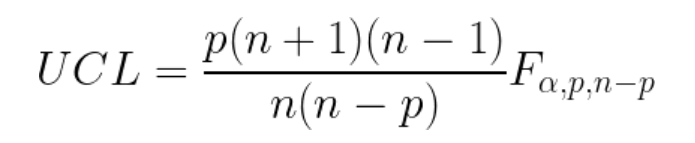

In [91]:
### UCL (Upeer control limit) ###

m = var_result.nobs
p = var_result.resid.shape[-1]
alpha = 0.01

UCL = stats.f.ppf(1-alpha, dfn=p, dfd=m-p) *(p*(m+1)*(m-1)/(m*m-m*p))
UCL

13.511575593053317

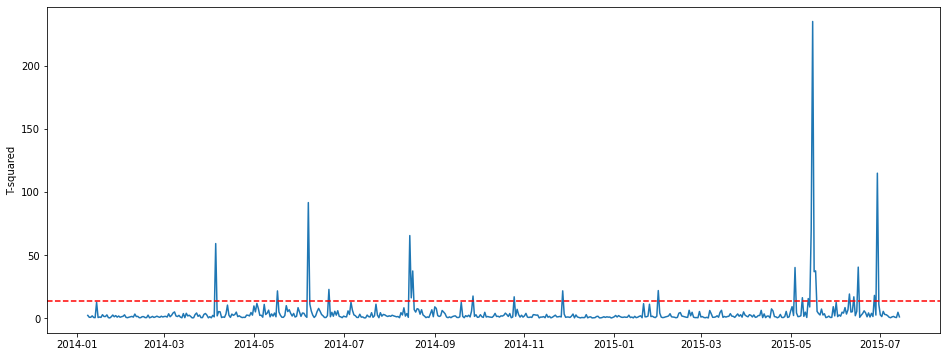

In [92]:
### PLOT del gráfico de control ###

plt.figure(figsize=(16,6))
plt.plot(train.index[best_order:], T)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [93]:
### TEST SPLIT CASO MULTIVARIANTE ###

test = df_day[(train_hours//24-best_order):].copy()
test.drop('Total', inplace=True, axis=1)

test.shape

(112, 4)

In [94]:
### REMOVER ESTACIONALIDAD A LARGO PLAZO (ANUAL) DEL DATASET DE PRUEBA ###

test['Ped South'] = test.apply(lambda x: x['Ped South'] - month_mean_train['Ped South'][x.name.month], axis=1)
test['Ped North'] = test.apply(lambda x: x['Ped North'] - month_mean_train['Ped North'][x.name.month], axis=1)
test['Bike South'] = test.apply(lambda x: x['Bike South'] - month_mean_train['Bike South'][x.name.month], axis=1)
test['Bike North'] = test.apply(lambda x: x['Bike North'] - month_mean_train['Bike North'][x.name.month], axis=1)

In [95]:
### PREDICCIONES ITERATIVAS DATASET DE PRUEBA ###

pred = []

for i in range(best_order, len(test)):
    
    pred.append(var_result.forecast(test.iloc[i-best_order:i].values, steps=1))
    
pred = np.vstack(pred)
pred.shape

(105, 4)

In [96]:
### ESTADISTICO T2 PARA EL DATASET DE PRUEBA ###

residuals_test = test.iloc[best_order:].values - pred
residuals_test = (residuals_test - residuals_mean) / residuals_std

T_test = np.diag((residuals_test).dot(cov_residuals).dot(residuals_test.T))

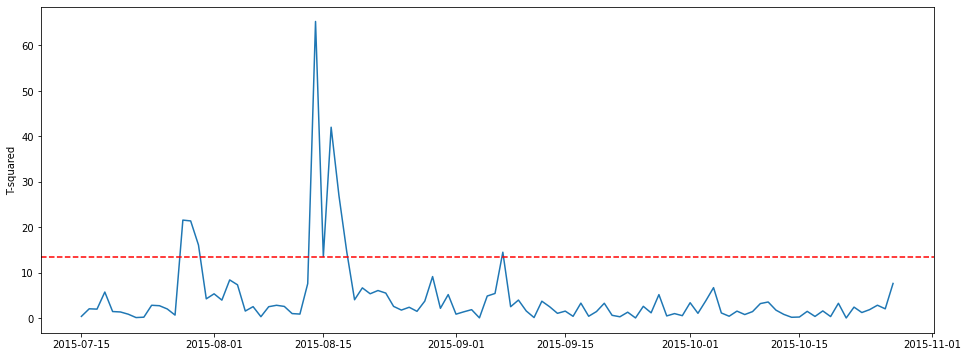

In [99]:
### PLOT DATASET DE PRUEBA ###

plt.figure(figsize=(16,6))
plt.plot(test.iloc[best_order:].index, T_test)
plt.ylabel('T-squared')
plt.axhline(UCL, c='red', linestyle='--')

In [100]:
### ¿CUÁLES SON LOS ATÍPICOS? ###

np.where(T_test>UCL)[0]

array([13, 14, 15, 30, 31, 32, 33, 34, 54])

# CONCLUSIONES


Atípicos detectados por método univariante, residuos:
45, 47 

Atípicos detectados por método univariante, intervalo de confianza:
10, 45, 53, 54

Atípicos detectados por método multivariante:
13, 14, 15, 30, 31, 32, 33, 34, 54